# 🔐 **Account Takeover Detection - Dataset Reducido (85K registros)**

## 🎯 **Objetivo**
Entrenar modelos de ML usando el **DATASET REDUCIDO** de 85K registros optimizado para laptops.

## 📊 **Dataset Reducido**
- **Total**: 85,141 registros (23.73 MB)
- **Account Takeover**: 141 casos (0.17%)
- **Normal**: 85,000 casos (99.83%)
- **Ratio**: 1:603 (Normal:ATO)
- **Ventaja**: Cabe completo en RAM, NO requiere chunks

## ⏱️ **Tiempo Estimado**
- Feature Engineering: 3-5 minutos
- Entrenamiento: 10-20 minutos
- **Total**: ~15-30 minutos

## 🎯 **Mejoras Implementadas**
- ✅ Temporal Split (NO random split - evita data leakage)
- ✅ SMOTE (balancea training set)
- ✅ Threshold Tuning (optimiza F1-Score)

---

## 📦 **FASE 0: Configuración e Imports**

In [1]:
import sys
import os
import warnings
import gc
warnings.filterwarnings('ignore')

sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import joblib

# Importar módulos del proyecto
from features.feature_engineering import engineer_features, save_features_and_encoders
from models.train import train_models, select_best_model, save_results

# Config
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Librerías importadas")
print(f"📅 Inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

✅ Librerías importadas
📅 Inicio: 2026-01-15 15:49:12


## 📂 **FASE 1: Configuración de Rutas y Parámetros**

In [2]:
# Rutas
DATASET_PATH = '../../processed_data/rba_reduced.csv'  # Dataset reducido (85K registros)
OUTPUT_DIR = '../outputs'
RANDOM_STATE = 42

# Crear directorios
import os
os.makedirs(f'{OUTPUT_DIR}/features', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/models', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/reports', exist_ok=True)

print(f"📁 Dataset: {DATASET_PATH}")
print(f"💾 Output dir: {OUTPUT_DIR}")
print(f"🎲 Random state: {RANDOM_STATE}")
print(f"\n✅ Dataset reducido (85K) cabe completo en RAM")
print(f"⏳ Tiempo estimado: 15-30 minutos")

📁 Dataset: ../../processed_data/rba_reduced.csv
💾 Output dir: ../outputs
🎲 Random state: 42

✅ Dataset reducido (85K) cabe completo en RAM
⏳ Tiempo estimado: 15-30 minutos


## 🔧 **FASE 2: Feature Engineering**

Procesar el dataset completo (cabe en RAM, sin chunks)

In [3]:
print("="*70)
print("🔧 INICIANDO FEATURE ENGINEERING")
print("="*70)
print(f"\n⏰ Inicio: {datetime.now().strftime('%H:%M:%S')}")

# Cargar dataset completo (85K registros caben en RAM)
print(f"\n⏳ Cargando dataset: {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)

print(f"✅ Dataset cargado: {len(df):,} registros")
print(f"   • Columnas: {len(df.columns)}")
print(f"   • ATOs: {df['Is Account Takeover'].sum()}")

# Feature engineering (carga única, sin chunks)
print(f"\n⏳ Aplicando feature engineering...")
features_df, encoders = engineer_features(df, fit_encoders=True)

print(f"\n✅ Feature Engineering completado")
print(f"   • Features creadas: {features_df.shape[1] - 1}")  # -1 por label
print(f"   • Registros procesados: {len(features_df):,}")

# Guardar encoders
encoders_path = f'{OUTPUT_DIR}/features/label_encoders.pkl'
joblib.dump(encoders, encoders_path)
print(f"💾 Encoders guardados: {encoders_path}")

print(f"\n⏰ Fin: {datetime.now().strftime('%H:%M:%S')}")
print("="*70)

🔧 INICIANDO FEATURE ENGINEERING

⏰ Inicio: 15:49:12

⏳ Cargando dataset: ../../processed_data/rba_reduced.csv
✅ Dataset cargado: 85,141 registros
   • Columnas: 16
   • ATOs: 141

⏳ Aplicando feature engineering...
🔧 INICIANDO FEATURE ENGINEERING - ACCOUNT TAKEOVER DETECTION

📊 Dataset input: 85,141 registros, 16 columnas
🕒 Parseando timestamps y extrayendo features temporales...
   ✅ Extracted temporal features: hour, day_of_week, is_weekend, is_night, is_business_hours
👤 Calculando features de comportamiento por usuario...
   ✅ Behavioral features: ip_changed, country_changed, browser_changed, device_changed, os_changed
   ✅ User aggregations: ip_count_per_user, country_count_per_user, success_rate_per_user
🌐 Calculando features de IP y red...
   ✅ IP features: user_count_per_ip, is_suspicious_ip, rtt_zscore, is_abnormal_rtt
🏷️  Encoding categorical features...
   ✅ Encoded 6 categorical features
🔗 Creando conjunto final de features...
   ✅ Total features: 35
      - Numeric: 4
     

## 📊 **FASE 3: Temporal Split Train/Test**

**IMPORTANTE**: Usar split temporal (NO random) para evitar data leakage en series temporales.

In [4]:
print("="*70)
print("📊 TEMPORAL SPLIT TRAIN/TEST")
print("="*70)

# Separar X y y
X = features_df.drop('label', axis=1)
y = features_df['label']

print(f"\n📊 Dataset completo:")
print(f"   Total: {len(y):,}")
print(f"   ATOs: {y.sum()} ({y.sum()/len(y)*100:.4f}%)")
print(f"   Normal: {len(y) - y.sum():,} ({(len(y) - y.sum())/len(y)*100:.4f}%)")

# TEMPORAL SPLIT (evita data leakage)
# Ordenar por Login Timestamp primero
print(f"\n⏳ Aplicando temporal split (80/20)...")
print(f"   ⚠️  NO usar random split - evita data leakage en series temporales")

# Asumimos que el index ya está ordenado temporalmente
# Si no, descomentar: features_df = features_df.sort_values('Login Timestamp')
train_size = int(0.8 * len(features_df))

# Split temporal
train_df = features_df.iloc[:train_size]
test_df = features_df.iloc[train_size:]

# Separar X e y
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

print(f"\n✅ Temporal Split completado:")
print(f"\n📊 TRAIN SET:")
print(f"   Total: {len(y_train):,}")
print(f"   ATOs: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.4f}%)")
print(f"   Normal: {len(y_train) - y_train.sum():,}")

print(f"\n📊 TEST SET:")
print(f"   Total: {len(y_test):,}")
print(f"   ATOs: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.4f}%)")
print(f"   Normal: {len(y_test) - y_test.sum():,}")

# Verificar que hay ATOs en ambos sets
if y_train.sum() == 0 or y_test.sum() == 0:
    print(f"\n⚠️  WARNING: Un set no tiene ATOs. Esto puede causar problemas.")
else:
    print(f"\n✅ Ambos sets tienen ATOs")

# Liberar memoria
del features_df
gc.collect()

📊 TEMPORAL SPLIT TRAIN/TEST

📊 Dataset completo:
   Total: 85,141
   ATOs: 141 (0.1656%)
   Normal: 85,000 (99.8344%)

⏳ Aplicando temporal split (80/20)...
   ⚠️  NO usar random split - evita data leakage en series temporales

✅ Temporal Split completado:

📊 TRAIN SET:
   Total: 68,112
   ATOs: 99 (0.1453%)
   Normal: 68,013

📊 TEST SET:
   Total: 17,029
   ATOs: 42 (0.2466%)
   Normal: 16,987

✅ Ambos sets tienen ATOs


24

## 🔄 **FASE 4: SMOTE - Balanceo de Training Set**

**SMOTE** (Synthetic Minority Over-sampling Technique): Genera muestras sintéticas de ATOs para balancear el training set.

**IMPORTANTE**: Solo aplicar a training set, NO a test set.

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, confusion_matrix

print("="*70)
print("🔄 APLICANDO SMOTE AL TRAINING SET")
print("="*70)

print(f"\n📊 ANTES DE SMOTE:")
print(f"   Train - ATOs: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.4f}%)")
print(f"   Train - Normal: {len(y_train) - y_train.sum():,}")

# Aplicar SMOTE
# sampling_strategy=0.1 significa: ATOs = 10% de Normal (más conservador)
smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.1, k_neighbors=5)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"\n📊 DESPUÉS DE SMOTE:")
print(f"   Train - ATOs: {y_train_sm.sum()} ({y_train_sm.sum()/len(y_train_sm)*100:.4f}%)")
print(f"   Train - Normal: {len(y_train_sm) - y_train_sm.sum():,}")
print(f"\n✅ ATOs sintéticos generados: {y_train_sm.sum() - y_train.sum():,}")
print(f"✅ Training set aumentado: {len(X_train_sm):,} registros (antes: {len(X_train):,})")

# Test set NO se modifica
print(f"\n📊 TEST SET (sin modificar):")
print(f"   Test - ATOs: {y_test.sum()}")
print(f"   Test - Normal: {len(y_test) - y_test.sum():,}")

print("="*70)

🔄 APLICANDO SMOTE AL TRAINING SET

📊 ANTES DE SMOTE:
   Train - ATOs: 99 (0.1453%)
   Train - Normal: 68,013

📊 DESPUÉS DE SMOTE:
   Train - ATOs: 6801 (9.0905%)
   Train - Normal: 68,013

✅ ATOs sintéticos generados: 6,702
✅ Training set aumentado: 74,814 registros (antes: 68,112)

📊 TEST SET (sin modificar):
   Test - ATOs: 42
   Test - Normal: 16,987


## 🚀 **FASE 5: Entrenamiento de Modelos**

Entrenaremos 4 modelos: Logistic Regression, Random Forest, SVM y Gradient Boosting.

**NOTA**: Esta fase tomará aproximadamente 10-20 minutos dependiendo del hardware.

In [6]:
# Configuración de modelos
config = {
    'random_state': RANDOM_STATE,
    'logistic_regression': {
        'max_iter': 1000,
        'n_jobs': -1,
        'class_weight': 'balanced',
        'solver': 'lbfgs'
    },
    'random_forest': {
        'n_estimators': 100,
        'max_depth': 15,
        'n_jobs': -1,
        'class_weight': 'balanced',
        'min_samples_split': 10,
        'min_samples_leaf': 5
    },
    'svm': {
        'kernel': 'rbf',
        'probability': True,
        'class_weight': 'balanced',
        'gamma': 'scale',
        'C': 1.0,
        'cache_size': 2000
    },
    'gradient_boosting': {
        'n_estimators': 100,
        'max_depth': 7,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'min_samples_split': 10
    }
}

print("="*70)
print("🚀 ENTRENAMIENTO DE MODELOS")
print("="*70)
print(f"\n⏰ Inicio: {datetime.now().strftime('%H:%M:%S')}")
print("\n⚙️  Configuración:")
print("   • Logistic Regression: class_weight='balanced'")
print("   • Random Forest: class_weight='balanced', n_estimators=100, max_depth=15")
print("   • SVM: class_weight='balanced', kernel='rbf'")
print("   • Gradient Boosting: n_estimators=100, max_depth=7")
print("\n⏱️  NOTA: Este proceso tomará aproximadamente 10-20 minutos.")
print("="*70)

🚀 ENTRENAMIENTO DE MODELOS

⏰ Inicio: 15:49:48

⚙️  Configuración:
   • Logistic Regression: class_weight='balanced'
   • Random Forest: class_weight='balanced', n_estimators=100, max_depth=15
   • SVM: class_weight='balanced', kernel='rbf'
   • Gradient Boosting: n_estimators=100, max_depth=7

⏱️  NOTA: Este proceso tomará aproximadamente 10-20 minutos.


In [7]:
# Entrenar modelos (usando datos con SMOTE)
print(f"\n⏳ Entrenando 4 modelos con datos balanceados por SMOTE...")
models_results = train_models(X_train_sm, X_test, y_train_sm, y_test, config=config)


⏳ Entrenando 4 modelos con datos balanceados por SMOTE...
🚀 Iniciando entrenamiento de modelos para ACCOUNT TAKEOVER DETECTION...
🔄 Train set: 74,814 samples, 35 features
🔄 Test set: 17,029 samples
📊 Train balance: ATO=6801 (9.09%), Normal=68013 (90.91%)
📊 Test balance: ATO=42 (0.25%), Normal=16987 (99.75%)

🤖 Entrenando: Logistic Regression

📊 Métricas para Logistic Regression:
   Accuracy:  0.4771
   Precision: 0.0041
   Recall:    0.8810
   F1-Score:  0.0082
   ROC-AUC:   0.7093
   AUC-PR:    0.0044
   FPR:       0.5239
   FNR:       0.1190

   Confusion Matrix:
   TN:  8088  FP:  8899
   FN:     5  TP:    37

🤖 Entrenando: Random Forest

📊 Métricas para Random Forest:
   Accuracy:  0.9900
   Precision: 0.1623
   Recall:    0.7381
   F1-Score:  0.2661
   ROC-AUC:   0.9625
   AUC-PR:    0.5318
   FPR:       0.0094
   FNR:       0.2619

   Confusion Matrix:
   TN: 16827  FP:   160
   FN:    11  TP:    31

🤖 Entrenando: SVM

📊 Métricas para SVM:
   Accuracy:  0.8155
   Precision: 0.01

## 📊 **FASE 6: Comparación de Modelos**

In [8]:
# Crear DataFrame de comparación
comparison_data = []
for model_name, results in models_results.items():
    metrics = results['metrics']
    comparison_data.append({
        'Modelo': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1_score']:.4f}",
        'ROC-AUC': f"{metrics.get('roc_auc', 0):.4f}",
        'AUC-PR': f"{metrics.get('average_precision', 0):.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("="*70)
print("📊 COMPARACIÓN DE MODELOS")
print("="*70)
display(comparison_df)

📊 COMPARACIÓN DE MODELOS


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,AUC-PR
0,Logistic Regression,0.4771,0.0041,0.8810,0.0082,0.7093,0.0044
1,Random Forest,0.9900,0.1623,0.7381,0.2661,0.9625,0.5318
2,SVM,0.8155,0.0101,0.7619,0.0200,0.8111,0.0196
3,Gradient Boosting,0.9988,0.7333,0.7857,0.7586,0.9806,0.7801


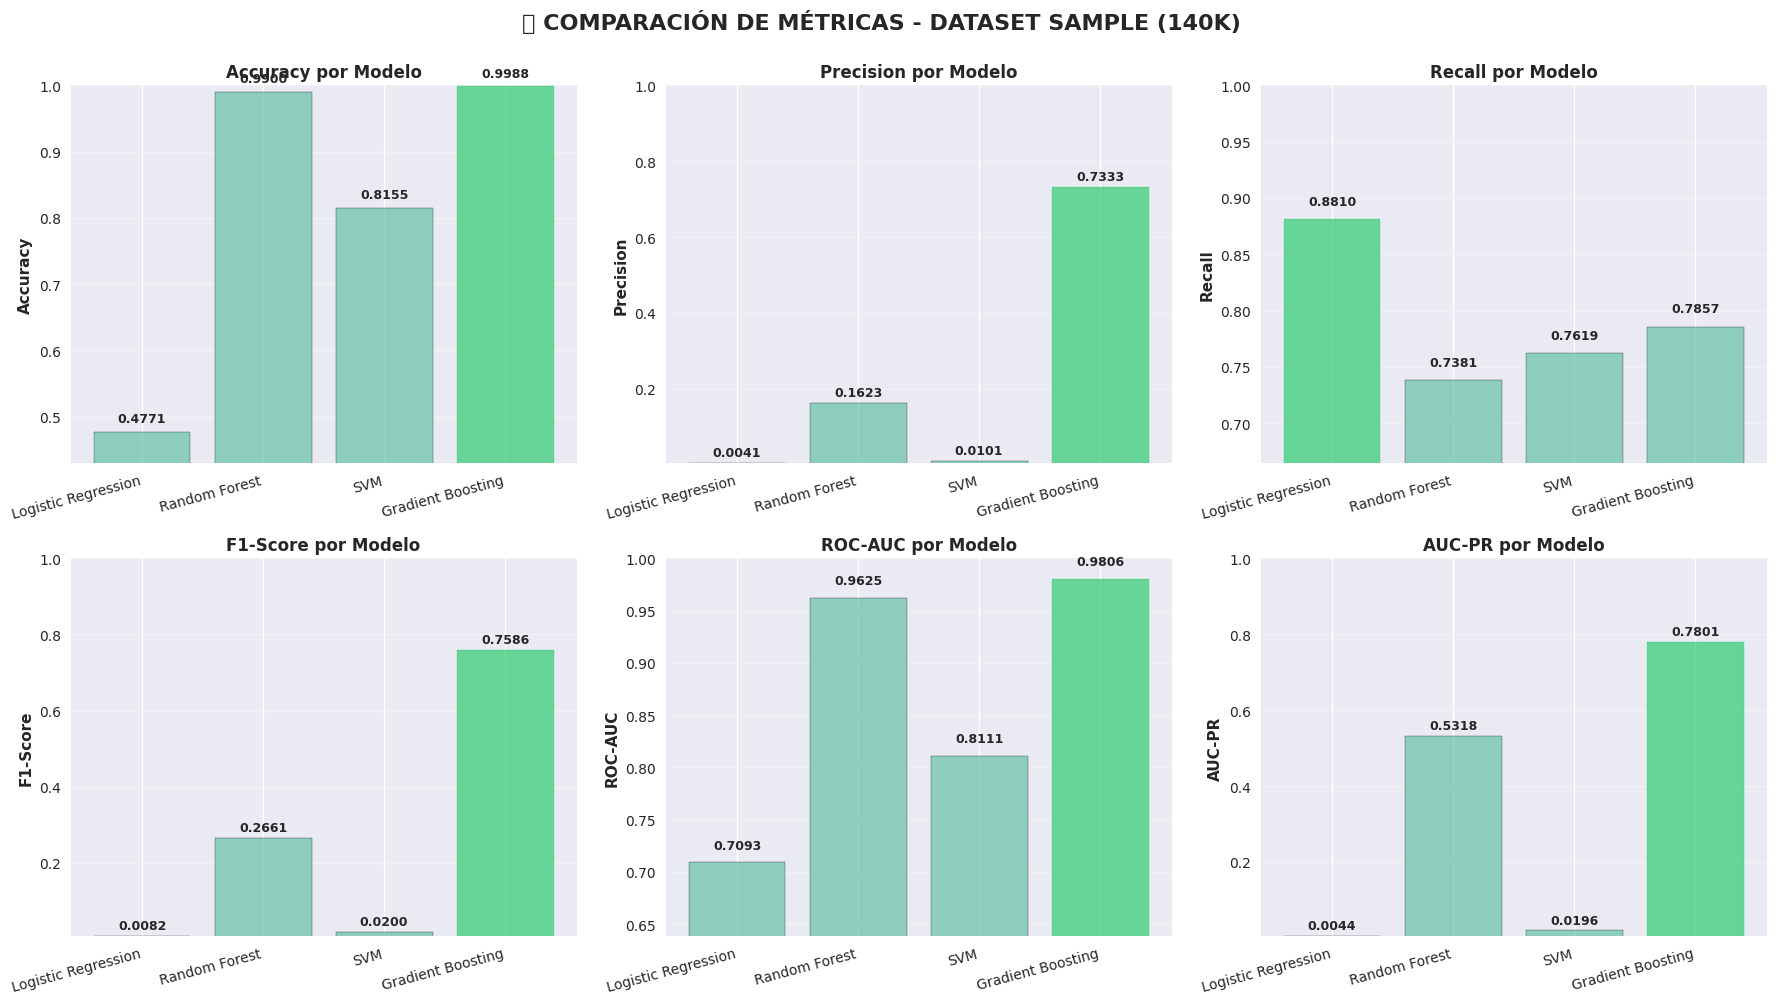

In [9]:
# Gráfico de comparación
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 COMPARACIÓN DE MÉTRICAS - DATASET SAMPLE (140K)', 
             fontsize=16, fontweight='bold', y=1.00)

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'average_precision']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUC-PR']

for idx, (metric, metric_name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx // 3, idx % 3]
    model_names = list(models_results.keys())
    values = [models_results[name]['metrics'].get(metric, 0) for name in model_names]
    bars = ax.bar(model_names, values, alpha=0.7, edgecolor='black')
    best_idx = values.index(max(values))
    bars[best_idx].set_color('#2ecc71')
    ax.set_ylabel(metric_name, fontweight='bold')
    ax.set_title(f'{metric_name} por Modelo', fontweight='bold')
    ax.set_ylim([min(values) * 0.90 if min(values) > 0 else 0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/reports/models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 🏆 **FASE 7: Selección del Mejor Modelo**

In [10]:
# Seleccionar mejor modelo
best_model_name, best_model, best_metrics = select_best_model(models_results, metric='f1_score')

print("\n🎯 Métricas del mejor modelo:")
for metric, value in best_metrics.items():
    if metric != 'confusion_matrix' and isinstance(value, (int, float)):
        print(f"   {metric}: {value:.4f}")


🏆 MEJOR MODELO: Gradient Boosting
🎯 F1_SCORE: 0.7586
📊 Precision: 0.7333
📊 Recall: 0.7857
📊 F1-Score: 0.7586

🎯 Métricas del mejor modelo:
   accuracy: 0.9988
   precision: 0.7333
   recall: 0.7857
   f1_score: 0.7586
   roc_auc: 0.9806
   average_precision: 0.7801
   false_positive_rate: 0.0007
   false_negative_rate: 0.2143


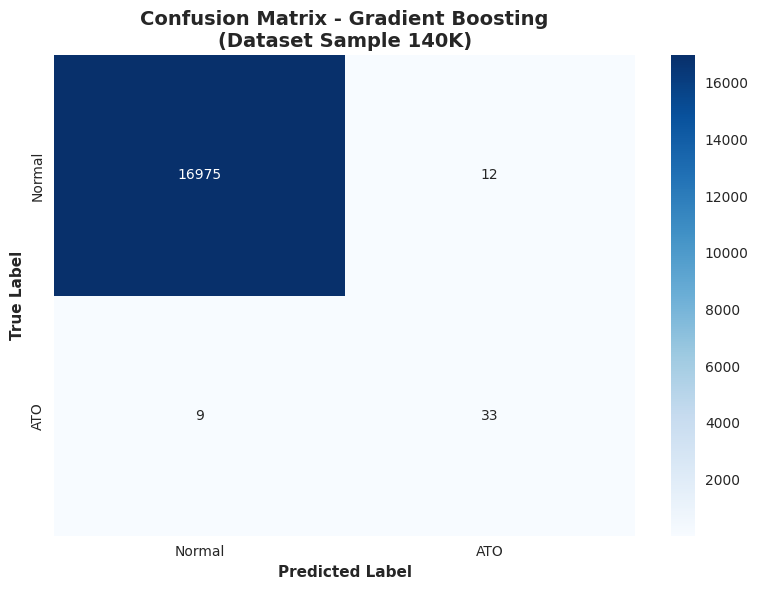


📊 Confusion Matrix:
   TN: 16,975 | FP: 12
   FN: 9 | TP: 33

📈 Tasas:
   FPR: 0.07%
   FNR: 21.43%


In [11]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix

best_predictions = models_results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'ATO'],
            yticklabels=['Normal', 'ATO'])
plt.title(f'Confusion Matrix - {best_model_name}\n(Dataset Sample 140K)', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/reports/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Métricas de confusión
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Confusion Matrix:")
print(f"   TN: {tn:,} | FP: {fp:,}")
print(f"   FN: {fn:,} | TP: {tp:,}")
print(f"\n📈 Tasas:")
print(f"   FPR: {fp/(fp+tn)*100:.2f}%")
print(f"   FNR: {fn/(fn+tp)*100:.2f}%")

## 🎯 **FASE 8: Threshold Tuning**

Optimizar threshold para maximizar F1-Score (con desbalance extremo, threshold óptimo NO es 0.5)

🎯 THRESHOLD TUNING

📊 THRESHOLD ANALYSIS:
   Default threshold: 0.5
   Optimal threshold: 0.9154

📊 COMPARACIÓN:
   F1-Score @ default (0.5): 0.7586
   F1-Score @ optimal (0.9154): 0.8101
   Mejora: 6.8%

📊 MÉTRICAS CON THRESHOLD OPTIMIZADO:
   Accuracy:  0.9991
   Precision: 0.8649
   Recall:    0.7619
   F1-Score:  0.8101

📊 CONFUSION MATRIX (Threshold Optimizado):
   TN: 16982  FP:     5
   FN:    10  TP:    32

   FPR: 0.03%
   FNR: 23.81%


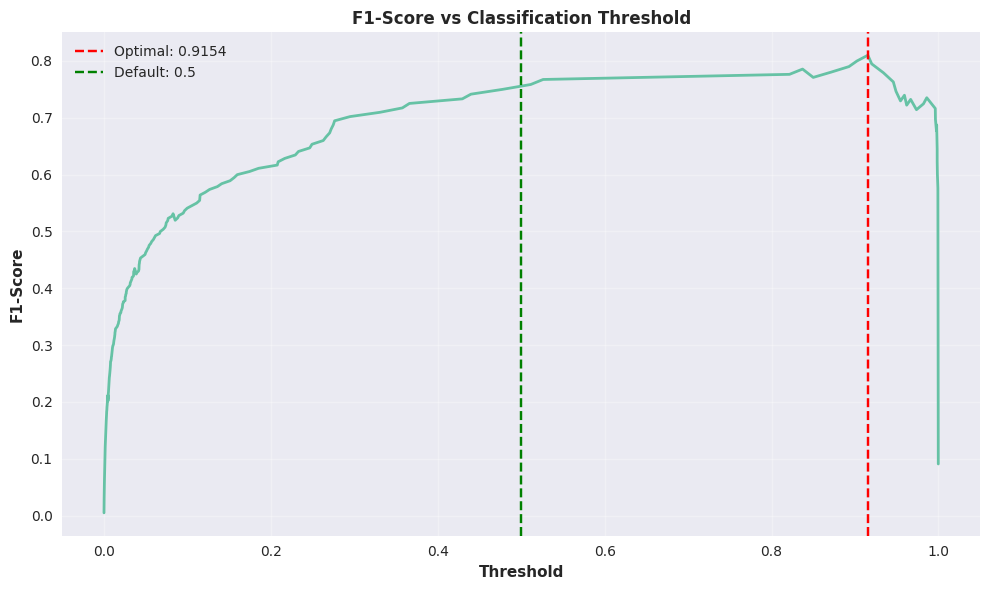


✅ Threshold óptimo encontrado: 0.9154
💾 Gráfico guardado: ../outputs/reports/threshold_tuning.png


In [12]:
print("="*70)
print("🎯 THRESHOLD TUNING")
print("="*70)

# Obtener probabilidades del mejor modelo
y_pred_proba = models_results[best_model_name]['probabilities']

if y_pred_proba is not None:
    # Calcular curva Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # Calcular F1-Score para cada threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Encontrar threshold óptimo
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    print(f"\n📊 THRESHOLD ANALYSIS:")
    print(f"   Default threshold: 0.5")
    print(f"   Optimal threshold: {optimal_threshold:.4f}")
    
    # Predicciones con threshold default
    y_pred_default = (y_pred_proba >= 0.5).astype(int)
    f1_default = f1_score(y_test, y_pred_default)
    
    # Predicciones con threshold optimizado
    y_pred_tuned = (y_pred_proba >= optimal_threshold).astype(int)
    f1_tuned = f1_score(y_test, y_pred_tuned)
    
    print(f"\n📊 COMPARACIÓN:")
    print(f"   F1-Score @ default (0.5): {f1_default:.4f}")
    print(f"   F1-Score @ optimal ({optimal_threshold:.4f}): {f1_tuned:.4f}")
    print(f"   Mejora: {((f1_tuned - f1_default)/f1_default*100):.1f}%")
    
    # Evaluar con threshold optimizado
    print(f"\n📊 MÉTRICAS CON THRESHOLD OPTIMIZADO:")
    metrics_tuned = {
        'accuracy': accuracy_score(y_test, y_pred_tuned),
        'precision': precision_score(y_test, y_pred_tuned, zero_division=0),
        'recall': recall_score(y_test, y_pred_tuned, zero_division=0),
        'f1_score': f1_tuned
    }
    
    print(f"   Accuracy:  {metrics_tuned['accuracy']:.4f}")
    print(f"   Precision: {metrics_tuned['precision']:.4f}")
    print(f"   Recall:    {metrics_tuned['recall']:.4f}")
    print(f"   F1-Score:  {metrics_tuned['f1_score']:.4f}")
    
    # Confusion Matrix con threshold optimizado
    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
    tn, fp, fn, tp = cm_tuned.ravel()
    
    print(f"\n📊 CONFUSION MATRIX (Threshold Optimizado):")
    print(f"   TN: {tn:5d}  FP: {fp:5d}")
    print(f"   FN: {fn:5d}  TP: {tp:5d}")
    print(f"\n   FPR: {fp/(fp+tn)*100:.2f}%")
    print(f"   FNR: {fn/(fn+tp)*100:.2f}%")
    
    # Gráfico de F1-Score vs Threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores[:-1], linewidth=2)
    plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.4f}')
    plt.axvline(0.5, color='g', linestyle='--', label='Default: 0.5')
    plt.xlabel('Threshold', fontweight='bold')
    plt.ylabel('F1-Score', fontweight='bold')
    plt.title('F1-Score vs Classification Threshold', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/reports/threshold_tuning.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Threshold óptimo encontrado: {optimal_threshold:.4f}")
    print(f"💾 Gráfico guardado: {OUTPUT_DIR}/reports/threshold_tuning.png")
    
else:
    print("\n⚠️  El mejor modelo no proporciona probabilidades. Threshold tuning no disponible.")

print("="*70)

## 💾 **FASE 9: Guardar Resultados**

In [13]:
# Guardar todos los modelos y resultados
model_info = save_results(models_results, best_model_name, OUTPUT_DIR, X_train_sm, y_test)
print("\n✅ Resultados guardados en:", OUTPUT_DIR)


💾 Guardando resultados en: ../outputs
✅ Mejor modelo guardado: ../outputs/models/best_model.pkl
✅ Metadata guardada: ../outputs/models/model_info.json
✅ Matrices de confusión guardadas en: ../outputs/reports
✅ Curvas ROC guardadas: ../outputs/reports/roc_curves_comparison.png
✅ Curvas Precision-Recall guardadas: ../outputs/reports/precision_recall_curves_comparison.png
✅ Reporte comparativo guardado: ../outputs/reports/models_comparison_report.txt

✅ Resultados guardados en: ../outputs


In [14]:
# Mostrar metadata del modelo guardado
import json

print("="*70)
print("📋 MODEL METADATA")
print("="*70)

if 'model_info' in locals():
    print(json.dumps(model_info, indent=2))
    
    # Verificar archivos guardados
    print("\n" + "="*70)
    print("📁 ARCHIVOS GUARDADOS")
    print("="*70)
    
    import os
    
    # Verificar modelos
    models_dir = f'{OUTPUT_DIR}/models'
    if os.path.exists(models_dir):
        model_files = os.listdir(models_dir)
        if model_files:
            print(f"\n🤖 Modelos guardados ({len(model_files)} archivos):")
            for file in sorted(model_files):
                file_path = os.path.join(models_dir, file)
                size_mb = os.path.getsize(file_path) / (1024 * 1024)
                print(f"   • {file} ({size_mb:.2f} MB)")
        else:
            print(f"\n⚠️  No se encontraron modelos en {models_dir}")
    
    # Verificar reportes
    reports_dir = f'{OUTPUT_DIR}/reports'
    if os.path.exists(reports_dir):
        report_files = os.listdir(reports_dir)
        if report_files:
            print(f"\n📊 Reportes guardados ({len(report_files)} archivos):")
            for file in sorted(report_files):
                print(f"   • {file}")
    
    # Verificar features
    features_dir = f'{OUTPUT_DIR}/features'
    if os.path.exists(features_dir):
        feature_files = os.listdir(features_dir)
        if feature_files:
            print(f"\n🔧 Features guardadas ({len(feature_files)} archivos):")
            for file in sorted(feature_files):
                print(f"   • {file}")
    
    print("\n" + "="*70)
else:
    print("\n⚠️  ERROR: model_info no está definido")
    print("   Ejecuta la celda anterior primero (save_results)")

📋 MODEL METADATA
{
  "timestamp": "2026-01-15T16:11:27.728631",
  "best_model": "Gradient Boosting",
  "best_metrics": {
    "accuracy": 0.9987668095601621,
    "precision": 0.7333333333333333,
    "recall": 0.7857142857142857,
    "f1_score": 0.7586206896551724,
    "roc_auc": 0.9806140269730074,
    "average_precision": 0.7801419089073472,
    "confusion_matrix": {
      "TN": 16975,
      "FP": 12,
      "FN": 9,
      "TP": 33
    },
    "false_positive_rate": 0.0007064225584270324,
    "false_negative_rate": 0.21428571428571427
  },
  "n_features": 35,
  "n_train_samples": 74814,
  "n_test_samples": 17029,
  "all_models_metrics": {
    "Logistic Regression": {
      "accuracy": 0.47712725350872043,
      "precision": 0.004140555058191585,
      "recall": 0.8809523809523809,
      "f1_score": 0.008242370238360436,
      "roc_auc": 0.7092832894622498,
      "average_precision": 0.004378438684259756,
      "confusion_matrix": {
        "TN": 8088,
        "FP": 8899,
        "FN": 5,

In [15]:
# Mostrar metadata
import json
print("📋 Model Info:")
print(json.dumps(model_info, indent=2))

📋 Model Info:
{
  "timestamp": "2026-01-15T16:11:27.728631",
  "best_model": "Gradient Boosting",
  "best_metrics": {
    "accuracy": 0.9987668095601621,
    "precision": 0.7333333333333333,
    "recall": 0.7857142857142857,
    "f1_score": 0.7586206896551724,
    "roc_auc": 0.9806140269730074,
    "average_precision": 0.7801419089073472,
    "confusion_matrix": {
      "TN": 16975,
      "FP": 12,
      "FN": 9,
      "TP": 33
    },
    "false_positive_rate": 0.0007064225584270324,
    "false_negative_rate": 0.21428571428571427
  },
  "n_features": 35,
  "n_train_samples": 74814,
  "n_test_samples": 17029,
  "all_models_metrics": {
    "Logistic Regression": {
      "accuracy": 0.47712725350872043,
      "precision": 0.004140555058191585,
      "recall": 0.8809523809523809,
      "f1_score": 0.008242370238360436,
      "roc_auc": 0.7092832894622498,
      "average_precision": 0.004378438684259756,
      "confusion_matrix": {
        "TN": 8088,
        "FP": 8899,
        "FN": 5,
  

## ✅ **RESUMEN FINAL**

In [16]:
print("="*70)
print("🎉 ENTRENAMIENTO COMPLETADO - DATASET REDUCIDO")
print("="*70)
print(f"\n📊 Dataset usado: RBA REDUCIDO (85K registros)")
print(f"   • Total procesado: {len(X_train_sm) + len(X_test):,}")
print(f"   • Train (con SMOTE): {len(X_train_sm):,}")
print(f"   • Test: {len(X_test):,}")
print(f"   • Features: 35")

print(f"\n🤖 Modelos entrenados: 4 (LR, RF, SVM, GB)")
for model_name in models_results.keys():
    f1 = models_results[model_name]['metrics']['f1_score']
    recall = models_results[model_name]['metrics']['recall']
    print(f"   • {model_name}: F1={f1:.4f}, Recall={recall:.4f}")

print(f"\n🏆 Mejor modelo: {best_model_name}")
print(f"   • F1-Score:  {best_metrics['f1_score']:.4f}")
print(f"   • Precision: {best_metrics['precision']:.4f}")
print(f"   • Recall:    {best_metrics['recall']:.4f}")
print(f"   • ROC-AUC:   {best_metrics.get('roc_auc', 0):.4f}")

print(f"\n💾 Outputs guardados en: {OUTPUT_DIR}")
print(f"   • Modelos: {OUTPUT_DIR}/models/")
print(f"   • Reportes: {OUTPUT_DIR}/reports/")
print(f"   • Features: {OUTPUT_DIR}/features/")

print(f"\n⏰ Fin: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

🎉 ENTRENAMIENTO COMPLETADO - DATASET REDUCIDO

📊 Dataset usado: RBA REDUCIDO (85K registros)
   • Total procesado: 91,843
   • Train (con SMOTE): 74,814
   • Test: 17,029
   • Features: 35

🤖 Modelos entrenados: 4 (LR, RF, SVM, GB)
   • Logistic Regression: F1=0.0082, Recall=0.8810
   • Random Forest: F1=0.2661, Recall=0.7381
   • SVM: F1=0.0200, Recall=0.7619
   • Gradient Boosting: F1=0.7586, Recall=0.7857

🏆 Mejor modelo: Gradient Boosting
   • F1-Score:  0.7586
   • Precision: 0.7333
   • Recall:    0.7857
   • ROC-AUC:   0.9806

💾 Outputs guardados en: ../outputs
   • Modelos: ../outputs/models/
   • Reportes: ../outputs/reports/
   • Features: ../outputs/features/

⏰ Fin: 2026-01-15 16:11:29
